# Post process results from the linear elastic 2D Cylinder analysis.





In [1]:
import scipy.sparse as spr
import scipy.sparse.linalg as spla
import sys
path2oti = '../../../../build/'
sys.path.append(path2oti) # Add path to OTI library.

import pyoti.real   as r
import pyoti.sparse as oti 
import pyoti.core   as coti
import pyoti.fem    as fem 

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

e  = oti.e
np = oti.np

import pyvista as pv
# p = pv.BackgroundPlotter()
pv.set_plot_theme('document')

global times
from timeit import default_timer as time

from matplotlib import rc

## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino'], 'size':16})
rc('text', usetex=True)

In [2]:
def cylinder(ri, ro, he = 1.0, element_order = 1, quads = False, 
           quad_incomplete = 1, quad_linear = 1, structured = False, save=False):
    """
    PORPUSE: Define a cylinder section mesh.
    """
    #***************************************************************************************************
    import gmsh

    gmsh.initialize()
    # gmsh.fltk.initialize()

    # Lets create a simple square element:
    model = gmsh.model
    geo   = model.geo
    option= gmsh.option

    P1 = geo.addPoint( 0.0, 0.0, 0.0, he, 1)
    P2 = geo.addPoint( 0.0,  ri, 0.0, he, 2)
    P3 = geo.addPoint(  ri, 0.0, 0.0, he, 3)
    P4 = geo.addPoint( 0.0,  ro, 0.0, he, 4)
    P5 = geo.addPoint(  ro, 0.0, 0.0, he, 5)

    C1 = geo.addCircleArc(P2,P1,P3)
    C2 = geo.addCircleArc(P5,P1,P4)
    
    geo.remove([P1])
    
    L1 = geo.addLine(P4,P2) # Left
    L2 = geo.addLine(P3,P5) # bottom

    loop1 = geo.addCurveLoop([C1,L2,C2,L1])

    surface = geo.addPlaneSurface([loop1])

    model.addPhysicalGroup( 0, [P1],        100 )
    model.addPhysicalGroup( 0, [P2],        101 )
    model.addPhysicalGroup( 0, [P3],        102 )
    model.addPhysicalGroup( 0, [P4],        103 )
    model.addPhysicalGroup( 0, [P5],        104 )

    model.addPhysicalGroup( 1, [C1],        201 )
    model.addPhysicalGroup( 1, [C2],        202 )
    model.addPhysicalGroup( 1, [L1],        203 )
    model.addPhysicalGroup( 1, [L2],        204 )

    model.addPhysicalGroup( 2, [surface],   301 )
    
    model.setPhysicalName( 0, 100, "center"  )
    model.setPhysicalName( 0, 101, "ri_left"  )
    model.setPhysicalName( 0, 102, "ri_right" )
    model.setPhysicalName( 0, 103, "ro_left"  )
    model.setPhysicalName( 0, 104, "ro_right" )

    model.setPhysicalName( 1, 201, "ri"    )
    model.setPhysicalName( 1, 202, "ro"    )
    model.setPhysicalName( 1, 203, "left"  )
    model.setPhysicalName( 1, 204, "right" )

    model.setPhysicalName( 2, 301, "domain"      )

    
    geo.synchronize()

    option.setNumber('Mesh.ElementOrder',element_order)


    # Recombine if quads are wanted.
    if quads:

        # Set body to recombine into quads.
        option.setNumber('Mesh.SecondOrderIncomplete',quad_incomplete)
        option.setNumber('Mesh.SecondOrderLinear',    quad_linear    )
        option.setNumber('Mesh.RecombineAll',         1)

    else:

        option.setNumber('Mesh.SecondOrderIncomplete',quad_incomplete)
        option.setNumber('Mesh.SecondOrderLinear',    quad_linear    )
        option.setNumber('Mesh.RecombineAll',         0)

    # end if 

    if structured:
        nels_L = int((ro-ri)/he)+1
        nels_C = min(int((ri*np.pi*2)/(4*he))+1,100)
        model.mesh.setTransfiniteCurve(L1,nels_L)
        model.mesh.setTransfiniteCurve(L2,nels_L)
        model.mesh.setTransfiniteCurve(C1,nels_C)
        model.mesh.setTransfiniteCurve(C2,nels_C)
        model.mesh.setTransfiniteSurface(surface)#,"left",[P2,P3,P4])
    # end if 

    model.mesh.generate(2)

    if save:
        gmsh.write("cylinder.msh")
    # end if 

    Th = fem.mesh.from_gmsh(gmsh)
#     Th = None

    gmsh.finalize()

    return Th

#-----------------------------------------------------------------------------------------------------

In [3]:
def analytic_solution_xy(x,y,E,nu,ri,pi,ro,po):
    
    A = ri**2*ro**2*(po-pi)/(ro**2-ri**2)
    B = (ri**2*pi - ro**2*po)/(ro**2-ri**2)
    
    r =  (x**2+y**2)**0.5
    
    ur = (1+nu)*r/E*((1-2*nu)*B-A/(r**2))
    
    ux = ur*x/r
    uy = ur*y/r
    
    return ux, uy

def analytic_solution_xy_r(x,y,E,nu,ri,pi,ro,po):
    
    A = ri**2*ro**2*(po-pi)/(ro**2-ri**2)
    B = (ri**2*pi - ro**2*po)/(ro**2-ri**2)
    
    r =  (x**2+y**2)**0.5
    
    ur = (1+nu)*r/E*((1-2*nu)*B-A/(r**2))
    
    ux = ur*x/r
    uy = ur*y/r
    
    return ur

In [4]:
fem.set_global_algebra(oti)
alg = fem.get_global_algebra()


Th = cylinder(1,2,he=0.01,element_order=2,quads=False,save=False, structured=True)

Th

/home/maristi7/anaconda3/envs/pyoti/lib/python3.7/site-packages/numpy/ctypeslib.py:521: RuntimeWarning: A builtin ctypes object gave a PEP3118 format string that does not match its itemsize, so a best-guess will be made of the data type. Newer versions of python may behave correctly.
  return array(obj, copy=False)


< mesh (pyoti.sparse) object with 40000 nodes, 20203 elements of types ( point1 (5), line3 (398), tri6 (19800) ) >

# For computation of error w.r.t nu, Pi and Po

In [5]:
order = 30

E  = alg.number(21e5)#+alg.e(2, order = order)
nu = alg.number(0.28)+alg.e(1, order = order)
ri = alg.number(1)
Pi = alg.number(10)+alg.e(2,order=order)
ro = alg.number(2)
Po = alg.number(1000)+oti.e(3,order=order)

In [5]:
order = 30

E  = alg.number(21e5)+alg.e(2, order = order)
nu = alg.number(0.28)#+alg.e(1, order = order)
ri = alg.number(1)
Pi = alg.number(10)# Pi = alg.number(1400)
ro = alg.number(2)+oti.e(1,order = order)
Po = alg.number(1000)

solver = 'cholesky'

# Perturb nodal coordinates for ro
pc = 1.0
for i in range(Th.x.size):
    
    x = Th.x[i,0]
    y = Th.y[i,0]
    
    r = alg.sqrt(x**2+y**2)
    if r.real > (ro-pc*(ro-ri)).real:
        
        h = (1-(ro-r)/(pc*(ro-ri))).real

        hx = h*x.real/r.real
        hy = h*y.real/r.real

        Th.x[i,0] = x.real + hx*alg.e(1, order = order)
        Th.y[i,0] = y.real + hy*alg.e(1, order = order)
        
    else:
        Th.x[i,0] = x.real
        Th.y[i,0] = y.real
# end for 

In [6]:
i = 0
delta = 1e30
angle = 30
theta = 0
for idx in Th.group_names['ri']['nodes']:
    x = Th.x[int(idx),0].real
    y = Th.y[int(idx),0].real
    if y != 0:
        theta = np.arctan(x/y)*180/np.pi
#         print(theta)
    # end if
    
    if np.abs(theta - angle) < delta:
        delta = np.abs(theta - angle)
        i = int(idx)
print(i)
idx = int(i)

37


In [7]:
u = oti.read("results/dro_pc100_dE_n30/u_dro_pc100_dE_n30.matso")
u_nu_Po_Pi = oti.read("results/dnu_dPo_dPi_n30/u_dnu_dPo_dPi_n30.matso")

In [19]:
u.shape

(40000, 3)

In [10]:
%timeit u.taylor_integrate([1,2],[0.01,0.01])
%timeit u_nu_Po_Pi.taylor_integrate([1,2],[0.01,0.01])

876 ms ± 9.23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
138 ms ± 976 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
orders_ti = np.array([30,20,15,10,8,6,4,3,2,1],dtype=np.uint8)
for ordi in orders_ti:
    
    u_for_ti = u.copy()
    # Truncate all ordi + 1 values 
    u_for_ti = u_for_ti.truncate([[1,ordi+1]])
    u_for_ti = u_for_ti.truncate([[2,ordi+1]])
    for oo in range(1,ordi+1):
        o1 = oo
        o2 = ordi+1-oo
        u_for_ti = u_for_ti.truncate([[1,o1],[2,o2]])
    print("Order: ",ordi)
    %timeit u_for_ti.taylor_integrate([1,2],[0.01,0.01])


Order:  30
882 ms ± 10.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Order:  20
316 ms ± 766 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Order:  15
162 ms ± 596 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Order:  10
73 ms ± 337 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Order:  8
51.7 ms ± 75.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Order:  6
37.6 ms ± 435 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Order:  4
29.1 ms ± 140 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Order:  3
24.5 ms ± 178 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Order:  2
21.4 ms ± 398 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Order:  1
21.7 ms ± 170 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
tr = np.linspace( -1.0*ro.real,1.0*ro.real, 200 )
tE = np.linspace( -1.0*E.real, 1.0*E.real,  200 )

Tr, TE = np.meshgrid(tr,tE)


orders_ti = np.array([30,20,15,10,8,6,4,3,2,1],dtype=np.uint8)
# orders_ti = np.array([5,],dtype=np.uint8)

error_ti = np.zeros((orders_ti.size,TE.shape[0],TE.shape[1]))

kk=0

ui = u[i]
xi = Th.x[i]
yi = Th.y[i]



for ordi in orders_ti:
    
    u_for_ti = ui.copy()
    # Truncate all ordi + 1 values 
    u_for_ti = u_for_ti.truncate([[1,ordi+1]])
    u_for_ti = u_for_ti.truncate([[2,ordi+1]])
    for oo in range(1,ordi+1):
        o1 = oo
        o2 = ordi+1-oo
#         print(o1, o2, o1+o2)
        u_for_ti = u_for_ti.truncate([[1,o1],[2,o2]])
    
#     print(u_for_ti)
#     print(u_for_ti)
    for ii in range(TE.shape[0]):
        for jj in range(TE.shape[1]):
            dr = Tr[ii,jj]
            dE = TE[ii,jj]
#             print(ii,jj)
            u_r_ti = np.linalg.norm(u_for_ti.taylor_integrate([1,2],[dr,dE]).real,axis=1).reshape((ui.shape[0],-1))
#         ux_a_ti, uy_a_ti = analytic_solution_xy(Th.x.taylor_integrate([1],[delta]).real,
#                                             Th.y.taylor_integrate([1],[delta]).real,
#                                             E.real,nu.real,ri.real,Pi.real,
#                                             ro.taylor_integrate([1],[delta]).real,Po.real)
            ux_a_ti, uy_a_ti = analytic_solution_xy(xi.taylor_integrate([1,2],[dr,dE]).real,
                                                yi.taylor_integrate([1,2],[dr,dE]).real,
                                                E.taylor_integrate([1,2],[dr,dE]).real,
                                                nu.real,
                                                ri.real,
                                                Pi.real,
                                                ro.taylor_integrate([1,2],[dr,dE]).real,
                                                Po.real)
            u_a_ti = np.zeros(ui.shape)
            u_a_ti[:,0:1]=ux_a_ti
            u_a_ti[:,1:2]=uy_a_ti
            u_ra_ti = np.linalg.norm(u_a_ti.real,axis=1).reshape((u_a_ti.shape[0],-1))

            error_ti[kk,ii,jj]=abs( (u_r_ti[0,0]-u_ra_ti[0,0])/(u_ra_ti[0,0]) )

        

    #
    kk+=1
    
error_ti

array([[[1.60591300e+09, 1.21054268e+09, 9.10272258e+08, ...,
         9.57155834e+07, 1.30892734e+08, 1.78424912e+08],
        [1.58993311e+09, 1.19825240e+09, 9.00838988e+08, ...,
         9.60417022e+07, 1.31335690e+08, 1.79024664e+08],
        [1.57426811e+09, 1.18620916e+09, 8.91599230e+08, ...,
         9.63700516e+07, 1.31781655e+08, 1.79628463e+08],
        ...,
        [5.38900270e+08, 4.00762633e+08, 2.97191506e+08, ...,
         2.89118115e+08, 3.90057787e+08, 5.24741494e+08],
        [5.37088815e+08, 3.99406396e+08, 2.96178915e+08, ...,
         2.92114283e+08, 3.94017929e+08, 5.29963018e+08],
        [5.35289498e+08, 3.98059307e+08, 2.95173200e+08, ...,
         2.95173202e+08, 3.98059309e+08, 5.35289500e+08]],

       [[1.56859935e+06, 1.30809278e+06, 1.08929573e+06, ...,
         1.14555967e+05, 1.41456528e+05, 1.74295130e+05],
        [1.55299076e+06, 1.29481212e+06, 1.07800725e+06, ...,
         1.14944629e+05, 1.41933585e+05, 1.74879354e+05],
        [1.53768974e+06, 

<IPython.core.display.Javascript object>


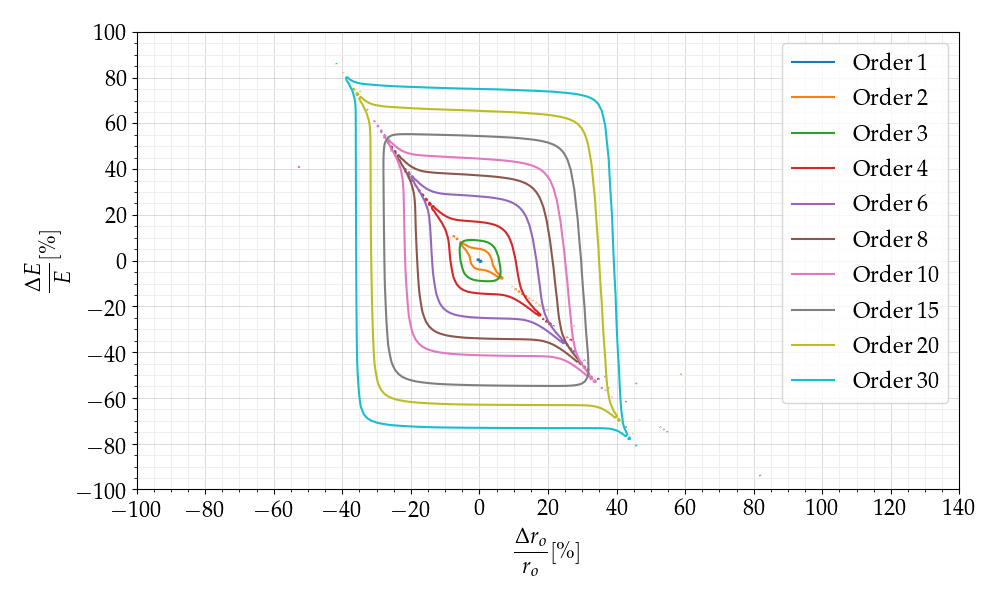

In [35]:
from matplotlib import ticker, cm, colors
from matplotlib.ticker import MultipleLocator
rc('font',**{'family':'serif','serif':['Palatino'], 'size':16})
             
fig = plt.figure(figsize=(10,6))
lev_exp = np.array([-7,-6,-5,-4,-3,-2,-1,0,1,2,14],dtype=np.float64)
levs = np.power(10, lev_exp)
# cs = ax.contourf(X, Y, z, levs, norm=colors.LogNorm())

# cp = plt.contourf(100*Tr/ro.real,100*TE/E.real,error_ti[0], levels=16,locator=ticker.LogLocator(10),norm=colors.LogNorm(vmax = 1e1), cmap=cm.jet)
# cp = plt.contourf(100*Tr/ro.real,100*TE/E.real,error_ti[0], levs,antialiased=True, norm=colors.LogNorm(vmax = 1e1), cmap=cm.jet)
# cbar = fig.colorbar(cp)

for kk in range(len(orders_ti)):
    CS=plt.contour(100*Tr/ro.real,100*TE/E.real,error_ti[-1-kk], [1e-4], colors = 'C'+str(kk))
    
#     plt.clabel(CS,fmt='Order '+str(orders_ti[kk]), inline=1, fontsize=12, colors='k')
#     plt.clabel(CS,fmt='Ord. '+str(orders_ti[-1-kk]), inline=1, fontsize=8, colors='k')
    
    CS.collections[0].set_label('Order '+str(orders_ti[-1-kk]))

# cbar.ax.set_ylabel("Relative error of \n$\\left.\\mathbf{u}(r_o+\\Delta r_o, E+\\Delta E)\\right|_{r_i}$")
plt.xlabel("$\\displaystyle{\\frac{\Delta r_o}{r_o}} [ \% ]$")
plt.ylabel("$\\displaystyle{\\frac{\Delta E}{E}} [ \% ]$")


ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_minor_locator(MultipleLocator(10))
plt.grid(which='major',color='#CCCCCC', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor',color='#EEEEEE')

plt.axis([-100,140,-100,100])
plt.legend()
plt.tight_layout()
plt.savefig('results/error_ti_Ero_orders.pdf',dpi=150)
plt.show()

In [105]:
E

2100000.0000 + 1.0000 * e([2])

In [106]:
# Compute the relative errors of the derivative dudro(ri) for all computed orders.
errors = np.zeros(order+1)

u_r = oti.sqrt( u[i,0]**2  + u[i,1]**2)
# u_r = ( u_nu_Po_Pi[i,0]**2  + u_nu_Po_Pi[i,1]**2)**0.5
xi = Th.x[i,0]
yi = Th.y[i,0]

uxa, uya = analytic_solution_xy( xi, yi,E,nu,ri,Pi,ro,Po) # Analytic
u_ra = oti.sqrt( uxa**2  + uya**2)
# u_ra = ( uxa**2  + uya**2)**0.5

# u_ra = -analytic_solution_xy_r(xi,yi,E,nu,ri,Pi,ro,Po)

u_rerr = np.abs(u_r.real - u_ra.real)/np.abs(u_ra.real)

errors[0] = u_rerr

for ordi in range(1,order + 1):
    dudE  = u_r.get_deriv( [[2,ordi]] )
    dudro = u_r.get_deriv( [[1,ordi]] )
    
    
    dudEa  = u_ra.get_deriv( [[2,ordi]] )
    dudroa = u_ra.get_deriv( [[1,ordi]] )

    errors[ordi] = np.abs(dudEa-dudE)/np.abs(dudEa)
    
#     errors[ordi] = np.abs(dudroa-dudro)/np.abs(dudroa)
    
# end for 
errors

array([3.93448745e-05, 3.93448732e-05, 3.93448718e-05, 3.93448703e-05,
       3.93448694e-05, 3.93448684e-05, 3.93448678e-05, 3.93448668e-05,
       3.93448665e-05, 3.93448652e-05, 3.93448644e-05, 3.93448627e-05,
       3.93448602e-05, 3.93448606e-05, 3.93448746e-05, 3.93448733e-05,
       3.93449617e-05, 3.93449828e-05, 3.93449860e-05, 3.93448113e-05,
       3.93576916e-05, 3.93837842e-05, 3.92138078e-05, 3.93744691e-05,
       3.92216499e-05, 4.20856013e-05, 5.05192969e-05, 5.80340621e+00,
       3.29323722e-05, 3.01091150e-05, 1.24375645e-02])

In [118]:
u_r.get_deriv( [[2,26]] )

1.9625725522505762e-141

In [119]:
u_ra.get_deriv( [[2,26]] )

1.962671705045073e-141

In [93]:
xi, yi,E,nu,ri,Pi,ro,Po

(0.5000,
 0.8660,
 2100000.0000 + 1.0000 * e([2]),
 0.2800,
 1.0000,
 10.0000,
 2.0000 + 1.0000 * e([1]),
 1000.0000)

In [154]:
ordi = 2
u_nu_Po_Pi[i,0].get_deriv([[1,ordi]]), u_nu_Po_Pi[i,1].get_deriv([[1,ordi]])

(-0.0012666491391007454, -0.002193903491209673)

In [130]:
u_nu_Po_Pi[i,1].get_deriv([[1,1]])

-0.0006184403944733579

In [147]:
ordi=5
oti.sqrt( u_nu_Po_Pi[i,0]**2  + u_nu_Po_Pi[i,1]**2).get_deriv([[1,ordi]])

2.2350423361597056e-05

In [151]:
np.abs(u_r.get_deriv([[1,2]]))

0.0025333007263888697

In [153]:
uxa.get_deriv([[1,2]]),uya.get_deriv([[1,2]])

(-0.00041837714390781556, -0.0007246504675474675)

In [161]:
# Compute the relative errors of the derivative dudro(ri) for all computed orders.
errors = np.zeros(order+1)

u_r = oti.sqrt( u_nu_Po_Pi[i,0]**2  + u_nu_Po_Pi[i,1]**2)
# u_r = ( u_nu_Po_Pi[i,0]**2  + u_nu_Po_Pi[i,1]**2)**0.5
xi = Th.x[i,0]
yi = Th.y[i,0]

uxa, uya = analytic_solution_xy( xi, yi,E,nu,ri,Pi,ro,Po) # Analytic
u_ra = oti.sqrt( uxa**2  + uya**2)
# u_ra = ( uxa**2  + uya**2)**0.5

u_ra = -analytic_solution_xy_r(xi,yi,E,nu,ri,Pi,ro,Po)

u_rerr = np.abs(u_r.real - u_ra.real)/np.abs(u_ra.real)

errors[0] = u_rerr

for ordi in range(1,order + 1):
    dudnu = u_r.get_deriv( [[1,ordi]] )
    dudPi = u_r.get_deriv( [[2,ordi]] )
    dudPo = u_r.get_deriv( [[3,ordi]] )
    
    dudnua = u_ra.get_deriv( [[1,ordi]] )
    dudPia = u_ra.get_deriv( [[2,ordi]] )
    dudPoa = u_ra.get_deriv( [[3,ordi]] )

    if ordi<=2:
        errors[ordi] = np.abs(dudnua-dudnu)/np.abs(dudnua)
    else:
        errors[ordi] = np.abs(dudnu)
    # 
#     errors[ordi] = np.abs(dudnua-dudnu)/np.abs(dudnua)
#     errors[ordi] = np.abs(dudPia-dudPi)/np.abs(dudPia)
#     errors[ordi] = np.abs(dudPoa-dudPo)/np.abs(dudPoa)
    
# end for 
errors

array([3.93448745e-05, 2.51903634e-05, 1.28711623e-05, 6.85857598e-08,
       1.09324381e-06, 2.23504234e-05, 5.56760218e-04, 1.63551048e-02,
       5.53718179e-01, 2.12395477e+01, 9.10696539e+02, 4.31782374e+04,
       2.24336882e+06, 1.26765581e+08, 7.74074587e+09, 5.07943071e+11,
       3.56460169e+13, 2.66410177e+15, 2.11238941e+17, 1.77134308e+19,
       1.56586447e+21, 1.45569298e+23, 1.41949943e+25, 1.44878370e+27,
       1.54465219e+29, 1.71712413e+31, 1.98693285e+33, 2.38962075e+35,
       2.98251493e+37, 3.85821714e+39, 5.16619214e+41])

In [185]:
# np.save("errors_tri6_h01_ndofs.npy",errors)
# errors



# Errors for case of h003 tri6 132734*2 DOFs full perturbation
errors_h003 = np.array([2.56086948e-05, 1.14080377e-04, 6.85504434e-05, 8.74219077e-05,
                        1.07142953e-04, 1.27469786e-04, 1.48155015e-04, 1.69036897e-04,
                        1.90022702e-04, 2.11062481e-04, 2.32129994e-04, 2.53211624e-04,
                        2.74300506e-04, 2.95393191e-04, 3.16488122e-04, 3.37584307e-04,
                        3.58681010e-04, 3.79778507e-04, 4.00876567e-04, 4.21974759e-04,
                        4.43073730e-04, 4.64172962e-04, 4.85272692e-04, 5.06372538e-04,
                        5.27473242e-04, 5.48573676e-04, 5.69675079e-04, 5.90776585e-04,
                        6.11878232e-04, 6.32980413e-04, 6.54083090e-04])

# Errors for case of h01 tri6 40000*2 DOFs full perturbation
errors_h01_100 = np.array([3.93448745e-05, 5.97914968e-05, 7.33593831e-05, 9.19072935e-05,
       1.11951434e-04, 1.32480222e-04, 1.53166564e-04, 1.73898974e-04,
       1.94644412e-04, 2.15396108e-04, 2.36152776e-04, 2.56912591e-04,
       2.77673564e-04, 2.98434580e-04, 3.19195660e-04, 3.39957309e-04,
       3.60719762e-04, 3.81483169e-04, 4.02247282e-04, 4.23012046e-04,
       4.43777256e-04, 4.64543015e-04, 4.85309347e-04, 5.06076280e-04,
       5.26843786e-04, 5.47611897e-04, 5.68380565e-04, 5.89149764e-04,
       6.09919729e-04, 6.30690282e-04, 6.51461708e-04])

errors_h01_25 = np.array([3.93448745e-05, 1.86232659e-04, 2.63511101e-05, 1.26557130e-05,
       1.24815069e-04, 2.60426669e-04, 4.04132030e-04, 5.52018937e-04,
       7.07056611e-04, 8.82319965e-04, 1.12849128e-03, 1.53064500e-03,
       2.66506834e-03, 5.42554179e-03, 1.45118431e-02, 1.96694251e-02,
       1.39537143e-02, 9.61933711e-03, 2.47790960e+00, 8.03949359e+00,
       9.08759988e+01, 3.11822178e+02, 9.44902209e+02, 6.00574845e+03,
       3.74602300e+04, 1.29611074e+05, 4.88765443e+05, 1.97270613e+06,
       6.66010039e+06, 4.17089279e+07, 1.85374814e+08])

errors_h01_50 = np.array([3.93448745e-05, 1.02327547e-04, 9.92380262e-05, 1.42352923e-04,
       1.98890373e-04, 2.59710797e-04, 3.21950103e-04, 3.84680703e-04,
       4.47622983e-04, 5.10728329e-04, 5.74085921e-04, 6.37832001e-04,
       7.02545944e-04, 7.68770409e-04, 8.38532517e-04, 9.14159007e-04,
       9.99404754e-04, 1.10933476e-03, 1.26627513e-03, 1.48388470e-03,
       1.83543188e-03, 2.36258273e-03, 3.61074691e-03, 5.49644247e-03,
       1.00088054e-02, 1.52796563e-02, 2.83872736e-02, 4.87119055e-02,
       1.24523666e-01, 1.85081310e-01, 2.92495183e-01])

errors_h01_75 = np.array([3.93448745e-05, 7.43616483e-05, 8.89456847e-05, 1.17785517e-04,
       1.50766709e-04, 1.85065103e-04, 2.19795013e-04, 2.54666563e-04,
       2.89584089e-04, 3.24516901e-04, 3.59454604e-04, 3.94395395e-04,
       4.29341097e-04, 4.64294017e-04, 4.99255018e-04, 5.34232834e-04,
       5.69234124e-04, 6.04263902e-04, 6.39330267e-04, 6.74457215e-04,
       7.09648788e-04, 7.44959411e-04, 7.80363751e-04, 8.15978378e-04,
       8.51756609e-04, 8.87822911e-04, 9.24407671e-04, 9.61101112e-04,
       9.98597419e-04, 1.03720177e-03, 1.07652118e-03])

# errors_h01_dudE = np.array([1.68228122e-05, 1.68228143e-05, 1.68228161e-05, 1.68228181e-05,
#        1.68228200e-05, 1.68228213e-05, 1.68228234e-05, 1.68228253e-05,
#        1.68228261e-05, 1.68228284e-05, 1.68228298e-05, 1.68228312e-05,
#        1.68228327e-05, 1.68228351e-05, 1.68228366e-05, 1.68228387e-05,
#        1.68228406e-05, 1.68228423e-05, 1.68228447e-05, 1.68228467e-05,
#        1.68228482e-05, 1.68228496e-05, 1.68228513e-05, 1.68228531e-05,
#        1.68228546e-05, 1.68228564e-05, 1.68228579e-05, 1.68228597e-05,
#        1.68228622e-05, 1.68228637e-05, 5.03289566e-05])

errors_h01_dudE = np.array([3.93448745e-05, 3.93448732e-05, 3.93448718e-05, 3.93448703e-05,
       3.93448694e-05, 3.93448684e-05, 3.93448678e-05, 3.93448668e-05,
       3.93448665e-05, 3.93448652e-05, 3.93448644e-05, 3.93448627e-05,
       3.93448602e-05, 3.93448606e-05, 3.93448746e-05, 3.93448733e-05,
       3.93449617e-05, 3.93449828e-05, 3.93449860e-05, 3.93448113e-05,
       3.93576916e-05, 3.93837842e-05, 3.92138078e-05, 3.93744691e-05,
       3.92216499e-05, 4.20856013e-05, 5.05192969e-05, 5.80340621e-05,
       3.29323722e-05, 3.01091150e-05, 1.24375645e-02])

# errors_h01_dudnu = np.array([3.93448745e-05, 2.51903634e-05, 1.28711623e-05, 6.02468551e+10,
#        1.46136151e+11, 4.04208372e+11, 1.72902580e+12, 7.25585454e+12,
#        2.98036226e+13, 5.53690845e+13, 9.59473663e+13, 8.86842293e+15,
#        2.18718915e+15, 2.26562079e+15, 9.50900224e+15, 4.52070206e+16,
#        2.00815299e+17, 1.14045617e+17, 1.68362118e+18, 1.49770543e+18,
#        1.51071307e+18, 3.89382271e+18, 9.61547602e+18, 1.62411505e+19,
#        3.36892662e+19, 1.66560147e+20, 8.73766574e+19, 1.13248798e+21,
#        1.35562556e+21, 7.84659371e+21, 8.00191476e+21])

errors_h01_dudnu = np.array([3.93448745e-05, 2.51903634e-05, 1.28711623e-05,            np.nan,
                  np.nan,            np.nan,            np.nan,            np.nan,
                  np.nan,            np.nan,            np.nan,            np.nan,
                  np.nan,            np.nan,            np.nan,            np.nan,
                  np.nan,            np.nan,            np.nan,            np.nan,
                  np.nan,            np.nan,            np.nan,            np.nan,
                  np.nan,            np.nan,            np.nan,            np.nan,
                  np.nan,            np.nan,            np.nan])


errors_h01_dudnu_abs = np.array([np.nan, np.nan, 1.28711623e-05, 6.85857598e-08,
       1.09324381e-06, 2.23504234e-05, 5.56760218e-04, 1.63551048e-02,
       5.53718179e-01, 2.12395477e+01, 9.10696539e+02, 4.31782374e+04,
       2.24336882e+06, 1.26765581e+08, 7.74074587e+09, 5.07943071e+11,
       3.56460169e+13, 2.66410177e+15, 2.11238941e+17, 1.77134308e+19,
       1.56586447e+21, 1.45569298e+23, 1.41949943e+25, 1.44878370e+27,
       1.54465219e+29, 1.71712413e+31, 1.98693285e+33, 2.38962075e+35,
       2.98251493e+37, 3.85821714e+39, 5.16619214e+41])

# errors_h01_dudPi = np.array([3.93448745e-05, 4.79082175e-05, 1.75000000e+00, 3.00000000e+00,
#        2.50000000e+00, 2.00000000e+00, 2.25000000e+00, 2.33333333e+00,
#        2.00000000e+00, 4.00000000e-01, 1.00000000e+00, 5.00000000e-01,
#        1.00000000e+00, 2.85714286e-01,            np.inf, 2.00000000e+00,
#        1.66666667e+00, 2.75000000e+00, 5.71428571e-01, 4.50000000e+00,
#        9.50000000e+00, 9.11764706e-01, 2.50000000e-01, 2.05882353e+00,
#        2.50000000e-01, 5.41666667e-01, 1.39062500e+00, 8.55555556e+00,
#        1.00000000e+00, 1.35294118e+00, 1.03738318e+00])
errors_h01_dudPi = np.array([3.93448745e-05, 4.79082175e-05, 0,0,
                  0,0,0,0,
                  0,0,0,0,
                  0,0,0,0,
                  0,0,0,0,
                  0,0,0,0,
                  0,0,0,0,
                  0,0,0])


errors_h01_dudPo = np.array([3.93448745e-05, 3.94108836e-05,0,0,
                  0,0,0,0,
                  0,0,0,0,
                  0,0,0,0,
                  0,0,0,0,
                  0,0,0,0,
                  0,0,0,0,
                  0,0,0])

<IPython.core.display.Javascript object>


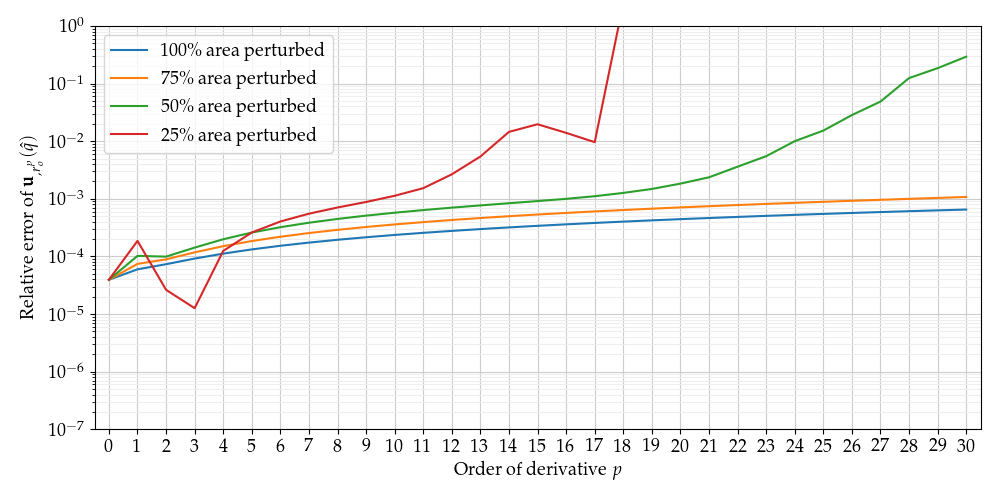

In [186]:
rc('font',**{'family':'serif','serif':['Palatino'], 'size':13})
plt.figure(figsize=(10,5))
new_order = 30
xvals  = range(new_order+1)#order+1)



yvals = errors_h01_100[:new_order+1]
plt.semilogy(xvals,yvals, label='100\% area perturbed')#'{0} DOFs'.format(132734*2))

yvals = errors_h01_75[:new_order+1]
plt.semilogy(xvals,yvals, label='75\% area perturbed')#'{0} DOFs'.format(132734*2))

yvals = errors_h01_50[:new_order+1]
plt.semilogy(xvals,yvals, label='50\% area perturbed')#'{0} DOFs'.format(132734*2))

yvals = errors_h01_25[:new_order+1]
plt.semilogy(xvals,yvals, label=' 25\% area perturbed')#'{0} DOFs'.format(40000*2))


# yvals = errors[:new_order+1]
# plt.semilogy(xvals,yvals, 'x-',label='{0} DOFs'.format(40000*2))

ax = plt.gca()

ax.xaxis.set_major_locator(MultipleLocator(1))

ax.set_axisbelow(True)
# plt.rc('xtick',fontsize=14)
plt.grid(which='major',color='#CCCCCC')
plt.minorticks_on()
plt.grid(which='minor',color='#EEEEEE')
ax.xaxis.set_minor_locator(MultipleLocator(1))
plt.axis([-0.5,len(xvals)-1+0.5,1e-7, 1e0])
plt.ylabel("Relative error of $\\mathbf{u}_{,r_{o}^{p}}(\hat{q})$")
plt.xlabel("Order of derivative $p$")
plt.legend()
plt.tight_layout()

plt.savefig("results/error_dudro_n"+str(new_order)+".pdf",dpi=150)
plt.show()

<IPython.core.display.Javascript object>


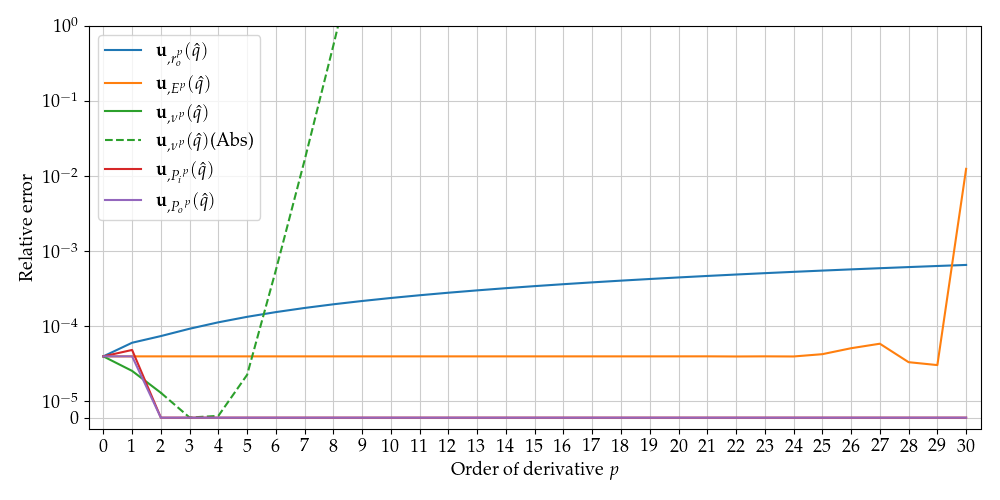

In [187]:
rc('font',**{'family':'serif','serif':['Palatino'], 'size':13})
plt.figure(figsize=(10,5))
new_order = 30
xvals  = range(new_order+1)#order+1)



yvals = errors_h01_100[:new_order+1]
plt.semilogy(xvals,yvals, label='$\\mathbf{u}_{,r_{o}^{p}}(\hat{q})$')#'{0} DOFs'.format(132734*2))

yvals = errors_h01_dudE[:new_order+1]
plt.semilogy(xvals,yvals, label='$\\mathbf{u}_{,E^p}(\hat{q})$')#'{0} DOFs'.format(132734*2))

yvals = errors_h01_dudnu[:new_order+1]
plt.semilogy(xvals,yvals, label='$\\mathbf{u}_{,\\nu^p}(\hat{q})$')#'{0} DOFs'.format(132734*2))

yvals = errors_h01_dudnu_abs[:new_order+1]
plt.semilogy(xvals,yvals, '--C2',label='$\\mathbf{u}_{,\\nu^p}(\hat{q})$(Abs)')#'{0} DOFs'.format(132734*2))

yvals = errors_h01_dudPi[:new_order+1]
plt.semilogy(xvals,yvals, label='$\\mathbf{u}_{,{P_i}^p}(\hat{q})$')#'{0} DOFs'.format(132734*2))

yvals = errors_h01_dudPo[:new_order+1]
plt.semilogy(xvals,yvals, label='$\\mathbf{u}_{,{P_o}^p}(\hat{q})$')#'{0} DOFs'.format(132734*2))


# yvals = errors[:new_order+1]
# plt.semilogy(xvals,yvals, 'x-',label='{0} DOFs'.format(40000*2))

ax = plt.gca()

ax.xaxis.set_major_locator(MultipleLocator(1))

ax.set_axisbelow(True)
plt.yscale('symlog',linthreshy=1e-5,linscaley=0.2)
# plt.rc('xtick',fontsize=14)
plt.grid(which='major',color='#CCCCCC')
plt.minorticks_on()
plt.grid(which='minor',color='#EEEEEE')
ax.xaxis.set_minor_locator(MultipleLocator(1))
plt.axis([-0.5,len(xvals)-1+0.5,-7e-6, 1e0])
plt.ylabel("Relative error")
plt.xlabel("Order of derivative $p$")
plt.legend()
plt.tight_layout()

plt.savefig("results/error_derivs_n"+str(new_order)+".pdf",dpi=150)
plt.show()

In [13]:
E

2100000.0000 + 1.0000 * e([2])

# Plot deformed data

<IPython.core.display.Javascript object>


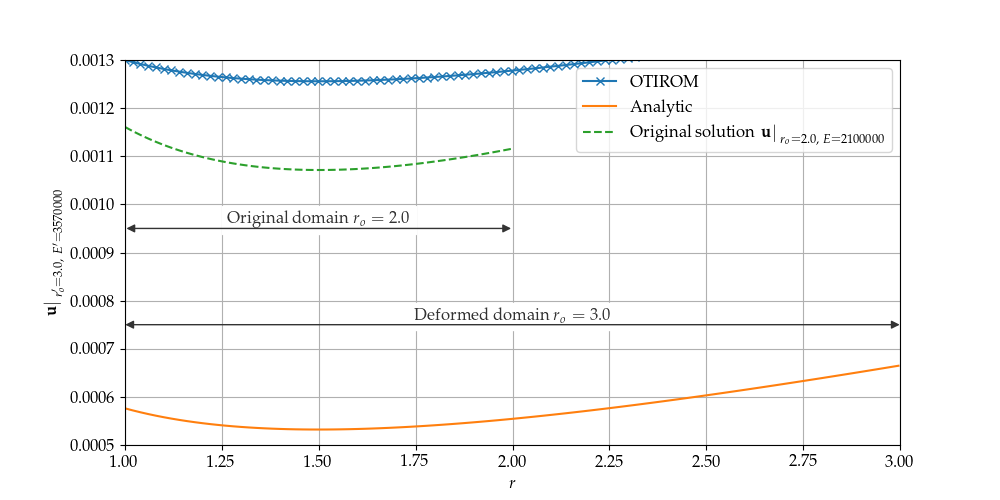

/home/maristi7/anaconda3/envs/pyoti/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/home/maristi7/anaconda3/envs/pyoti/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  
/home/maristi7/anaconda3/envs/pyoti/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/home/maristi7/anaconda3/envs/pyoti/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


In [36]:
rc('font',**{'family':'serif','serif':['Palatino'], 'size':12})

plt.figure(figsize=(10,5))






dr = ro.real*0.5
dE = E.real*0.7






u_r_ti = np.linalg.norm(u.taylor_integrate([1,2],[dr,dE]).real,axis=1).reshape((u.shape[0],-1))


grid = Th.to_pv(pd = [u_r_ti],pd_names=['u'])
eps = 1e-3

a = [(ri.real+eps)*np.cos(np.pi/6),(ri.real+eps)*np.sin(np.pi/6),0]
b = [(ro.real-eps)*np.cos(np.pi/6),(ro.real-eps)*np.sin(np.pi/6),0]

grid.plot_over_line(a, b, resolution=100, figure=False, show=False )

ax = plt.gca()

lines = ax.get_lines()
line = lines[0]
line.set_label("OTIROM")
line.set_marker("x")

x = line.get_xdata()
line.set_xdata(x*(1+dr)+ri.real)










ux_a_ti, uy_a_ti = analytic_solution_xy(Th.x.taylor_integrate([1,2],[dr,dE]).real,
                                        Th.y.taylor_integrate([1,2],[dr,dE]).real,
                                        E.taylor_integrate([1,2],[dr,dE]).real,
                                        nu.real,
                                        ri.real,
                                        Pi.real,
                                        ro.taylor_integrate([1,2],[dr,dE]).real,
                                        Po.real)

u_a_ti = np.zeros(u.shape)
u_a_ti[:,0:1]=ux_a_ti
u_a_ti[:,1:2]=uy_a_ti
u_ra_ti = np.linalg.norm(u_a_ti.real,axis=1).reshape((u.shape[0],-1))
















grid = Th.to_pv(pd = [u_ra_ti],pd_names=['ua'])

f  = grid.plot_over_line(a, b, resolution=100, figure=False, show=False )

lines = ax.get_lines()
line = lines[-1]
line.set_label("Analytic")

x = line.get_xdata()
line.set_xdata(x*(1+dr)+ri.real)







ux_a, uy_a = analytic_solution_xy(Th.x.real,
                                        Th.y.real,
                                        E.real,
                                        nu.real,
                                        ri.real,
                                        Pi.real,
                                        ro.real,
                                        Po.real)
u_a = np.zeros(u.shape)
u_a[:,0:1]=ux_a
u_a[:,1:2]=uy_a
u_ra = np.linalg.norm(u_a.real,axis=1).reshape((u.shape[0],-1))





grid = Th.to_pv(pd = [u_ra],pd_names=['ustrt'])

f  = grid.plot_over_line(a, b, resolution=100, figure=False, show=False )

lines = ax.get_lines()
line = lines[-1]
line.set_label("Original solution $\\left.\\mathbf{{u}}\\right|_{{\\;r_o={0},\\;E={1:.0f}}}$".format(ro.real,E.real))

x = line.get_xdata()
line.set_xdata(x+ri.real)
line.set_linestyle('--')





# Plot annotations
x1 = 1; x2 = 2
y1 = 0.00095; y2 = 0.00095


ax.text((x1+x2)*.5, y1, "Original domain $r_o={0}$".format(ro.real),
         ha="center", va="bottom",color="0.2",backgroundcolor='w')

ax.annotate("",
            xy=(x1, y1), xycoords='data',
            xytext=(x2, y2), textcoords='data',
            arrowprops=dict(arrowstyle="<|-|>", color="0.2",
                            shrinkA=1, shrinkB=1,
                            patchA=None, patchB=None,
                            connectionstyle="arc3,rad=0.",
                            ),
            )




x1 = 1; x2 = 2+dr
y1 = 0.00075; y2 = 0.00075


ax.text((x1 + x2)*0.5, y1, "Deformed domain $r_o={0}$".format((ro+dr).real),
         ha="center", va="bottom",color="0.2",backgroundcolor='w')

ax.annotate("",
            xy=(x1, y1), xycoords='data',
            xytext=(x2, y2), textcoords='data',
            arrowprops=dict(arrowstyle="<|-|>", color="0.2",
                            shrinkA=0.2, shrinkB=0.2,
                            patchA=None, patchB=None,
                            connectionstyle="arc3,rad=0.",
                            ),
            )








plt.xlabel("$r$")
plt.ylabel("$\\left.\\mathbf{{u}}\\right|_{{\;r_o'={0},\;E'={1:.0f}}}$".format(ro.real+dr,E.real+dE))
# plt.title("OTI solution vs Analytic solution")
plt.title("")
plt.grid()
# plt.legend(loc='upper center', ncol=3)
plt.legend()
plt.axis([ri.real,ro.real+dr,0.0005,0.0013])
plt.savefig("results/solution_u_ti_dr{0}_dE{1}.pdf".format(dr,dE),dpi=150)
#plt.legend()
plt.show()

In [34]:
E

2100000.0000 + 1.0000 * e([2])

# Plot mesh perturbations

In [347]:
fem.set_global_algebra(oti)
alg = fem.get_global_algebra()


Th2 = cylinder(1,2,he=0.05,element_order=1,quads=False,save=False, structured=True)


order = 1

pfunc = np.ones(Th2.nnodes)*-1

# Perturb nodal coordinates for ro
pc = 0.49
for i in range(Th2.x.size):
    
    x = Th2.x[i,0]
    y = Th2.y[i,0]
    
    r = alg.sqrt(x**2+y**2)
    if r.real > (ro-pc*(ro-ri)).real:
        
        h = (1-(ro-r)/(pc*(ro-ri))).real
        pfunc[i]=h
        hx = h*x.real/r.real
        hy = h*y.real/r.real

        Th2.x[i,0] = x.real + hx*alg.e(1, order = order)
        Th2.y[i,0] = y.real + hy*alg.e(1, order = order)
        
    else:
        Th2.x[i,0] = x.real
        Th2.y[i,0] = y.real
# end for 


Th2

/home/maristi7/anaconda3/envs/pyoti/lib/python3.7/site-packages/numpy/ctypeslib.py:521: RuntimeWarning: A builtin ctypes object gave a PEP3118 format string that does not match its itemsize, so a best-guess will be made of the data type. Newer versions of python may behave correctly.
  return array(obj, copy=False)


< mesh (pyoti.sparse) object with 673 nodes, 1347 elements of types ( point1 (5), line2 (102), tri3 (1240) ) >

In [348]:
tri = Th2.elements[2]['indices'][0][:,:3]
nodes = np.zeros((Th2.nnodes,2))
nodes[:,0:1]=Th2.x.real
nodes[:,1:2]=Th2.y.real

In [349]:
masks = np.ones(tri.shape[0],dtype=bool)
k=0
for t in tri:
    if pfunc[t[0]]!=-1 or pfunc[t[1]]!=-1 or pfunc[t[2]]!=-1 :
        masks[k]=False
    k+=1
masks
masks

array([ True,  True,  True, ..., False, False, False])

<IPython.core.display.Javascript object>


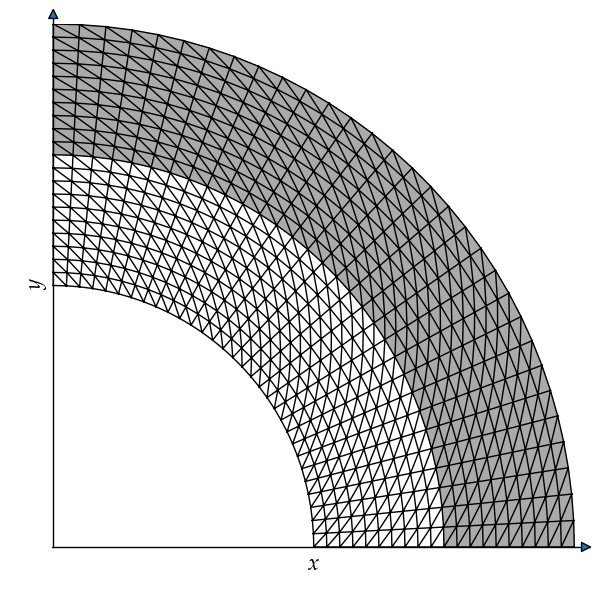

/home/maristi7/anaconda3/envs/pyoti/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: The following kwargs were not used by contour: 'triangles', 'mask'


In [350]:
from matplotlib.ticker import MultipleLocator
rc('font',**{'family':'serif','serif':['Palatino'], 'size':16})
from matplotlib import ticker, cm, colors
from mpl_toolkits.axisartist.axislines import SubplotZero


# cm.jet.set_under('white')
fig = plt.figure(figsize=(6,6))

ax = SubplotZero(fig, 1, 1, 1)
fig.add_subplot(ax)

cp = ax.tricontourf(nodes[:,0],
                  nodes[:,1],
                 pfunc,
                  triangles=tri, mask=masks,
                  colors='#AAAAAA',
#                      cmap=cm.jet,
                    vmin=0,vmax=1)

cp = ax.triplot(nodes[:,0],
                  nodes[:,1],
                  tri,
                  color='black', linewidth=1.0)
ax.axis["xzero"].set_visible(True)
ax.axis["xzero"].label.set_text("$x$")
ax.axis["xzero"].set_axisline_style("-|>")
ax.axis["xzero"].toggle(ticklabels=False,ticks=False)

ax.axis["yzero"].set_visible(True)
ax.axis["yzero"].label.set_text("$y$")
ax.axis["yzero"].set_axis_direction("left")
ax.axis["yzero"].set_axisline_style("-|>")
ax.axis["yzero"].toggle(ticklabels=False,ticks=False)
# plt.xlabel("$x$")
# plt.ylabel("$y$")
# make other axis (bottom, top, right) invisible.
for n in ["bottom", "top", "right","left"]:
    ax.axis[n].set_visible(False)

ax = plt.gca()
# ax.xaxis.set_major_locator(MultipleLocator(20))
# ax.yaxis.set_major_locator(MultipleLocator(20))
# plt.grid(color='#222222', linewidth=0.5)
plt.axis('equal')

plt.tight_layout()
plt.savefig('shape_perturb_'+str(int(pc*100))+'.pdf',dpi=150)
plt.show()


In [330]:
bb = ax.axis["xzero"]

In [333]:
bb.major_ticks.set_visible

TypeError: 'Ticks' object is not callable